In [1]:
import pickle
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
from itertools import count

def edge2node(edge_context) :
    '''
    edge_list : str, like 'ENSG00000115415 ENSG00000138496_ENSG00000115415 ENSG00000168961_ENSG00000115415, underline as seperator
    '''
    edge_l = edge_context.split('_')
    node_l = set(list(map(lambda x : x.split(' ')[0],edge_l)) + list(map(lambda x : x.split(' ')[1],edge_l)))
    return list(node_l)

def construct_module_interaction_network(module_xl,sheet_list) :
    '''
    module_xl : pd.ExcelFile; contain functional module information
    sheet_list : list; which sheet will be used to construct network
    '''
    g = nx.Graph()
    node_dict = {}
    description_dict = {}
    for sheet in sheet_list :
        df = module_xl.parse(sheet)
        for i in range(df.shape[0]):
            go = df.loc[i,'GOID']
            description_dict[go] = df.loc[i,'Description']
            edge = df.loc[i,'Edges']
            nodes = edge2node(edge)
            for n in nodes :
                node_dict[n] = go
                edge_list = [(x.split(' ')[0],x.split(' ')[1],{'GO' : go,'Condition' : sheet}) for x in edge.split('_')]
                g.add_edges_from(edge_list)
        nx.set_node_attributes(g,node_dict,name='GO')
    return g,description_dict

def remove_edges_without_candidate_gene(g,candidate_genes) :
    rm_list = []
    for gene1,gene2 in g.edges :
        if gene1 not in candidate_genes and gene2 not in candidate_genes :
            rm_list.append((gene1,gene2))
    g.remove_edges_from(rm_list)

def plot_gene_interaction_network(g,description_dict,ens2hgsc,output_path,degree_threshold=10,cmap=plt.cm.Set3,fig_size = (20,12)) :
    '''
    g : nx.Graph(); gene interaction network of candidate functional modules, node in graph have GO attribute.
    description_dict : dict; go to go description converter
    '''
    # get unique groups
    groups = set(nx.get_node_attributes(g,'GO').values())
    mapping = dict(zip(sorted(groups),count()))
    nodes = g.nodes()
    colors = [mapping[g.nodes[n]['GO']] for n in nodes]

    color_val_to_go = {}
    for key,val in mapping.items() :
        color_val_to_go[val] = description_dict[key]

    plt.figure(figsize=fig_size)
    pos = nx.kamada_kawai_layout(g)
    values = [x[1] * 100 for x in g.degree()]

    labels = {}
    for key,val in g.degree() :
        if val > degree_threshold and key in pos:
            labels[key] = ens2hgsc[key]
        
    nx.draw_networkx_nodes(g, pos, cmap=cmap, node_size = values,node_color=colors)
    nx.draw_networkx_labels(g,pos, labels)
    nx.draw_networkx_edges(g, pos,alpha=0.2)

    for v in set(colors):
        plt.scatter([],[], c=[cmap(v/max(colors))], label='{}'.format(color_val_to_go[v]))

    plt.legend(bbox_to_anchor=(1,1))
    plt.savefig(output_path,bbox_inches='tight',dpi=300)

In [3]:
with open("/home/bruce1996/data/LIHC_anomaly_detection/data/coding_gene_info/hgnc2ensembl.pkl",'rb') as f :
    hgsc2ens = pickle.load(f)
f.close()
ens2hgsc = {}
for hgsc,ens in hgsc2ens.items() :
    ens2hgsc[ens] = hgsc

In [12]:
functional_module_path = '/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/'
ppi = 'PIN'
ppi_xl = pd.ExcelFile(functional_module_path + 'Summary_table_of_%s_FunModu.xlsx' % ppi)
condition = ['hbv_only_35','tumor_only_25']
g,description_dict = construct_module_interaction_network(ppi_xl,condition)

In [13]:
survival_summary = pd.read_csv("cox_regression_summary_of_%s_module.txt" % ppi,sep='\t',index_col=0)
candidate_hgsc = survival_summary['Gene'][survival_summary['#Nmodule'] > 2].unique()
candidate_hgsc = [x.replace('.','-') if '.' in x else x for x in candidate_hgsc]
candidate_genes = [hgsc2ens[x] for x in candidate_hgsc]
remove_edges_without_candidate_gene(g,candidate_genes)

In [14]:
candidate_hgsc

['PNP', 'HMGB1', 'CSF1', 'IL2RG', 'GBP2', 'ATP5MG', 'LEPR', 'ATP5PO']

In [15]:
survival_summary

,Gene,p-value,liri_p-value,Go,Description,Condition,#Nmodule
6,PNP,3.610533e-04,3.610533e-04,GO:0051251,positive-regulation-of-lymphocyte-activation,hbv_only_35,10
0,PNP,6.974630e-03,6.974630e-03,GO:0009165,nucleotide-biosynthetic-process,tumor_only_25,10
7,PNP,7.478475e-04,7.478475e-04,GO:0050670,regulation-of-lymphocyte-proliferation,hbv_only_35,10
1,PNP,7.672208e-03,7.672208e-03,GO:0072522,purine-containing-compound-biosynthetic-process,tumor_only_25,10
6,PNP,6.194533e-04,6.194533e-04,GO:0042098,T-cell-proliferation,hbv_only_35,10
...,...,...,...,...,...,...,...
0,HPRT1,6.028086e-03,6.028086e-03,GO:0072522,purine-containing-compound-biosynthetic-process,tumor_only_25,1
5,HLA.DRB1,1.545586e-02,1.545586e-02,GO:1903037,regulation-of-leukocyte-cell-cell-adhesion,hbv_only_35,1
25,HLA.DPA1,0.000000e+00,0.000000e+00,GO:0071345,cellular-response-to-cytokine-stimulus,tumor_only_25,1
67,HCLS1,0.000000e+00,0.000000e+00,GO:0071345,cellular-response-to-cytokine-stimulus,tumor_only_25,1


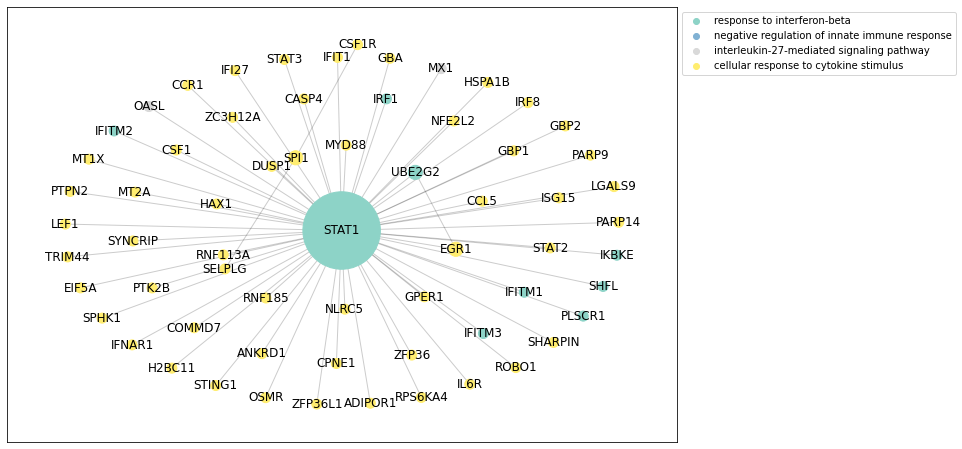

In [7]:
fig_path = "/home/bruce1996/data/LIHC_anomaly_detection/fig/functional_module/interaction_network/%s_survival_associated_gene_interaction_network.png" % ppi
plot_gene_interaction_network(g,description_dict,ens2hgsc,output_path=fig_path,degree_threshold=0,fig_size=(12,8))

In [107]:
survival_summary

,Gene,p-value,liri_p-value,Go,Description,Condition,#Nmodule
14,SELPLG,3.770993e-02,3.770993e-02,GO:0071345,cellular-response-to-cytokine-stimulus,hbv_only_35,4
14,SELPLG,2.807026e-02,2.807026e-02,GO:0071345,cellular-response-to-cytokine-stimulus,hbv_only_35,4
14,SELPLG,9.977771e-04,9.977771e-04,GO:0071345,cellular-response-to-cytokine-stimulus,tumor_only_25,4
14,SELPLG,0.000000e+00,0.000000e+00,GO:0071345,cellular-response-to-cytokine-stimulus,tumor_only_25,4
87,UBE2G2,3.793651e-12,3.793651e-12,GO:0071345,cellular-response-to-cytokine-stimulus,tumor_only_25,3
...,...,...,...,...,...,...,...
33,IL15RA,1.334854e-48,1.334854e-48,GO:0071345,cellular-response-to-cytokine-stimulus,tumor_only_25,1
25,IFNAR1,2.182761e-13,2.182761e-13,GO:0071345,cellular-response-to-cytokine-stimulus,tumor_only_25,1
39,IFITM2,1.809315e-02,1.809315e-02,GO:0071345,cellular-response-to-cytokine-stimulus,tumor_only_25,1
24,IFI27,4.942706e-02,4.942706e-02,GO:0071345,cellular-response-to-cytokine-stimulus,tumor_only_25,1
